In [ ]:
# !pip install pymystem3
# !pip install sentence-transformers
# !pip install umap-learn
# !pip install hdbscan

# Загрузка библиотек и данных

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re
import gensim
import bz2
import _pickle as cPickle

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import Counter
from nltk.tokenize import sent_tokenize, word_tokenize
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')
from bs4 import BeautifulSoup

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score

import umap # метод понижения размерности
import hdbscan # метод кластеризации
from sentence_transformers import SentenceTransformer

import matplotlib
from matplotlib.colors import ListedColormap
import pylab
matplotlib.rc('xtick', labelsize=13)
matplotlib.rc('ytick', labelsize=13)
matplotlib.rcParams.update({'font.size': 15})

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'
pylab.rcParams['figure.figsize'] = 8, 6

# Парсинг исходных данных

In [ ]:
from lxml import etree
from bs4 import BeautifulSoup
import csv
import time
import numpy as np

MYFILE = 'event_202010291122.xml'

start_time = time.time()
data = []
tags = []
n = 1e4 # кол-во записей для извлечения

for event, elem in etree.iterparse(MYFILE, encoding='cp1251'):
    text, tag = elem.text, elem.tag
    elem.clear()
    for ancestor in elem.xpath('ancestor-or-self::*'):
        while ancestor.getprevious() is not None:
            del ancestor.getparent()[0]
    data.append(text)
    if tag not in set(tags):
        tags.append(tag)
    if len(data)/5==n:
        break

print('Прочитано {} элементов'.format(int(n)))
print('Заняло {} секунд'.format(np.round(time.time() - start_time)))
print('Размер данных: {}Mb'.format(np.round(data.__sizeof__()/1e6)))

with open('fadn.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows([tags[1:4]])
    writer.writerows(list(zip(data[1::5], data[2::5], data[3::5])))
    

# Занимает в 5 раз меньше места
# import bz2
# import _pickle as cPickle

# def compressed_pickle(title, data):
#     with bz2.BZ2File(title + '.pbz2', 'w') as f: 
#         cPickle.dump(data, f)
        
# compressed_pickle('example_cp', data) 
    
# # Load any compressed pickle file
# def decompress_pickle(file):
#     data = bz2.BZ2File(file, 'rb')
#     data = cPickle.load(data)
#     return data

Прочитано 10000 элементов
Заняло 2.0 секунд
Размер данных: 0.0Mb


In [ ]:
df = pd.read_csv('fadn.csv')
df = df.rename(columns = {'event_title':'title', 'event_text':'text', 'event_date':'date'})

In [ ]:
#df = df.iloc[:5000]
df.head(5)

,title,text,date
0,Жильцы затопленных после циклона домов на Саха...,"Жильцы домов, подтопленных в результате циклон...",2020-10-25 03:15:37
1,"В Тольятти ""Калина"" сбила мотоциклиста на ""Ямахе""",Водителя двухко­лесного транс­порта госпи­та­л...,2020-10-16 06:34:04
2,Пятьдесят сахалинских одиноких стариков и инва...,За заботу о них островитянам будут платить В С...,2020-08-10 09:51:00
3,Протесты в Берлине: пострадали не менее 45 пол...,2 Авг. 2020 2020-08-02T18:00:53+03:00 Изменить...,2020-08-02 14:36:29
4,NaN,"Моя повесть, которую я писала почти 20 лет.\n-...",2020-10-24 20:26:07


In [ ]:
print(df.shape, df.__sizeof__()/1.024e6)

(10000, 3) 59.234044921875


In [ ]:
df.isna().sum()

title    4888
text        0
date        0
dtype: int64

# Препроцессинг данных

In [ ]:
# Функции для предобработки текста
STOP_WORDS = nltk.corpus.stopwords.words('russian')
from pymystem3 import Mystem

def remove_nonASCII(text):
    """Удаляем non-ASCII символы"""
    #cleaned_text = ''.join([x for x in text if x in string.printable])
    return re.sub(r'[^А-Яа-яA-Za-z0-9]+', ' ', text)

def replace_e(text):
    return re.sub(r'ё', 'е', text)

def remove_URL(text):
    """Удаляем ссылки"""
    url = re.compile(r'http\S+|www\.\S+|[\.com]$')
    return url.sub(r'',text)

def remove_punct(text):
    """Удаляем знаки препинания"""
    return re.sub(r'[^\w\s]', '', text)

def remove_individ_letters(text):
    """Удаляем одиночные буквы"""
    return re.sub(r'\b\w.{,2}\b','', text)

def remove_numbers(text):
    """Удаляем цифры"""
    return re.sub(r'\d*','', text) 

def remove_stop_words(text):
    """Удаление стоп слов"""
    new_sent = ' '.join([i for i in text.split() if i not in STOP_WORDS])
    return new_sent

def process_text(text):
    text = replace_e(text)
    text = remove_nonASCII(text)
    text = remove_URL(text)
    text = remove_numbers(text)
    text = remove_punct(text)
    text = remove_individ_letters(text)
    return text

def lemmatizer(text):
    lem = Mystem()
    return ' '.join([lem.lemmatize(word)[0] for word in word_tokenize(text)])

def clean_text(text, lemmatize=True, remove_stopwords=True):
    """Очищаем текст"""
    if remove_stopwords:
        text = remove_stop_words(text.lower())
    text = process_text(text)
    if lemmatize:
        text = lemmatizer(text)
    return text

In [ ]:
df.sort_values(by='date', ascending=False, inplace=True)

In [ ]:
df['text'] = df['text'].apply(lambda x: str(BeautifulSoup(x, 'html.parser')))

In [ ]:
%%time
df['cleaned_text'] = df['text'].apply(lambda x: clean_text(x, lemmatize=False)) # очищаем текст

In [ ]:
%%time
df['word_tokens'] = df['cleaned_summary'].apply(lambda x: word_tokenize(lemmatizer(x))) # токены слов

In [ ]:
%%time
# токены предложений
df['sent_tokens'] = df['text'].apply(lambda x:[clean_text(sent, 
                                                              lemmatize=False, 
                                                              remove_stopwords=False) for sent in sent_tokenize(x)])

CPU times: user 1.95 s, sys: 23.6 ms, total: 1.98 s
Wall time: 1.99 s


In [ ]:
from gensim.summarization import summarize

df['gensim_summary'] = 0
for i in range(df.shape[0]):
    try:
        df['gensim_summary'].iloc[i] = summarize(df['text'].iloc[i], ratio=0.2)
        
        if len(df['gensim_summary'].iloc[i]) == 0:
            df['gensim_summary'].iloc[i] = df['text'].iloc[i]
    except:
        df['gensim_summary'].iloc[i] = df['text'].iloc[i]

In [ ]:
df['cleaned_summary'] = df['gensim_summary'].apply(lambda x: clean_text(x, lemmatize=True)) # очищаем текст

# Кластеризация и выделение главных слов

In [ ]:
bert_model = SentenceTransformer('xlm-r-bert-base-nli-stsb-mean-tokens') # подгружаем претренированного Берта

In [ ]:
bert_embeddings = bert_model.encode(df['cleaned_summary'], show_progress_bar=True) # создаем эмбеддинги

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,1), min_df = 5, max_df = 500, max_features=50000) # слова -> вектора
tfidf_matrix = vectorizer.fit_transform(df['cleaned_summary'])
print(tfidf_matrix.shape)

(10000, 21767)


In [ ]:
# Понижение размерности и кластеризация
embeddings = bert_embeddings
#embeddings = tfidf_matrix

umap_embeddings = umap.UMAP(n_neighbors=20, 
                            n_components=5,
                            metric='cosine').fit_transform(embeddings)

cluster_labels = MiniBatchKMeans(n_clusters=6, batch_size=100, random_state=17).fit_predict(umap_embeddings)
# cluster = hdbscan.HDBSCAN(min_cluster_size=10,
#                           metric='euclidean',                      
#                           cluster_selection_method='leaf').fit(umap_embeddings)
# labels = cluster.labels_

# def get_top_keywords_tfidf(data, clusters, tokens, n_terms):
#     try:
#         data = data.todense()
#     except:
#         pass
#     df = pd.DataFrame(data).groupby(clusters).mean()
#     terms = []
#     for i,r in df.iterrows():
#         #print('\nCluster {}'.format(i))
#         #print(','.join([tokens[t] for t in np.argsort(r)[-n_terms:]]))
#         terms.append(', '.join([tokens[t] for t in np.argsort(r)[-n_terms:]]))
#     return terms

# terms_new = get_top_keywords_tfidf(embeddings, cluster_labels, vectorizer.get_feature_names(), 5)

# Определение ключевых слов в образованных кластерах -------
column_name = 'cleaned_summary'
docs_df = pd.DataFrame(df[column_name])
docs_df['Topic'] = cluster_labels
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({column_name: ' '.join})

vectorizer = TfidfVectorizer(ngram_range=(1,1), min_df=10, max_df=300)
tf_idf_topics = vectorizer.fit_transform(df[column_name]).toarray()

words = vectorizer.get_feature_names()
labels = list(docs_per_topic['Topic'])
indices = tf_idf_topics.argsort()[:, -5:]
top_n_words = {label: 
               [(words[j], tf_idf_topics[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}

topics_sum = (docs_df.groupby(['Topic'])[column_name]
                  .count()
                  .reset_index()
                  .rename({"Topic": "Topic", column_name: "Size"}, axis='columns'))

for i in range(len(topics_sum)):
    topics_sum.loc[i, 'top_words']=', '.join([i[0] for i in top_n_words[i]])
    
topics_sum.sort_values("Size", ascending=False).head(10)

,Topic,Size,top_words
4,4,2004,"нижней, польского, запрета, участвовали, прохо..."
2,2,1785,"челябинск, друг, близкий, илия, романа"
3,3,1777,"ожоги, волгограда, многоквартирном, оборудован..."
5,5,1601,"решительно, командующий, иран, press, армией"
1,1,1589,"росреестра, ипотека, псковской, управление, пр..."
0,0,1244,"макрона, франции, карикатур, пророка, публикации"


In [ ]:
terms

['квартиру, фото, деньги, album, онлайн',
 'twitter, против, дело, азербайджана, армении',
 'пресс, рублей, улице, районе, домов',
 'ребенка, тебе, сказал, жизнь, детей',
 'церкви, русские, войны, русских, народов',
 'выборов, беларуси, президента, белоруссии, лукашенко']

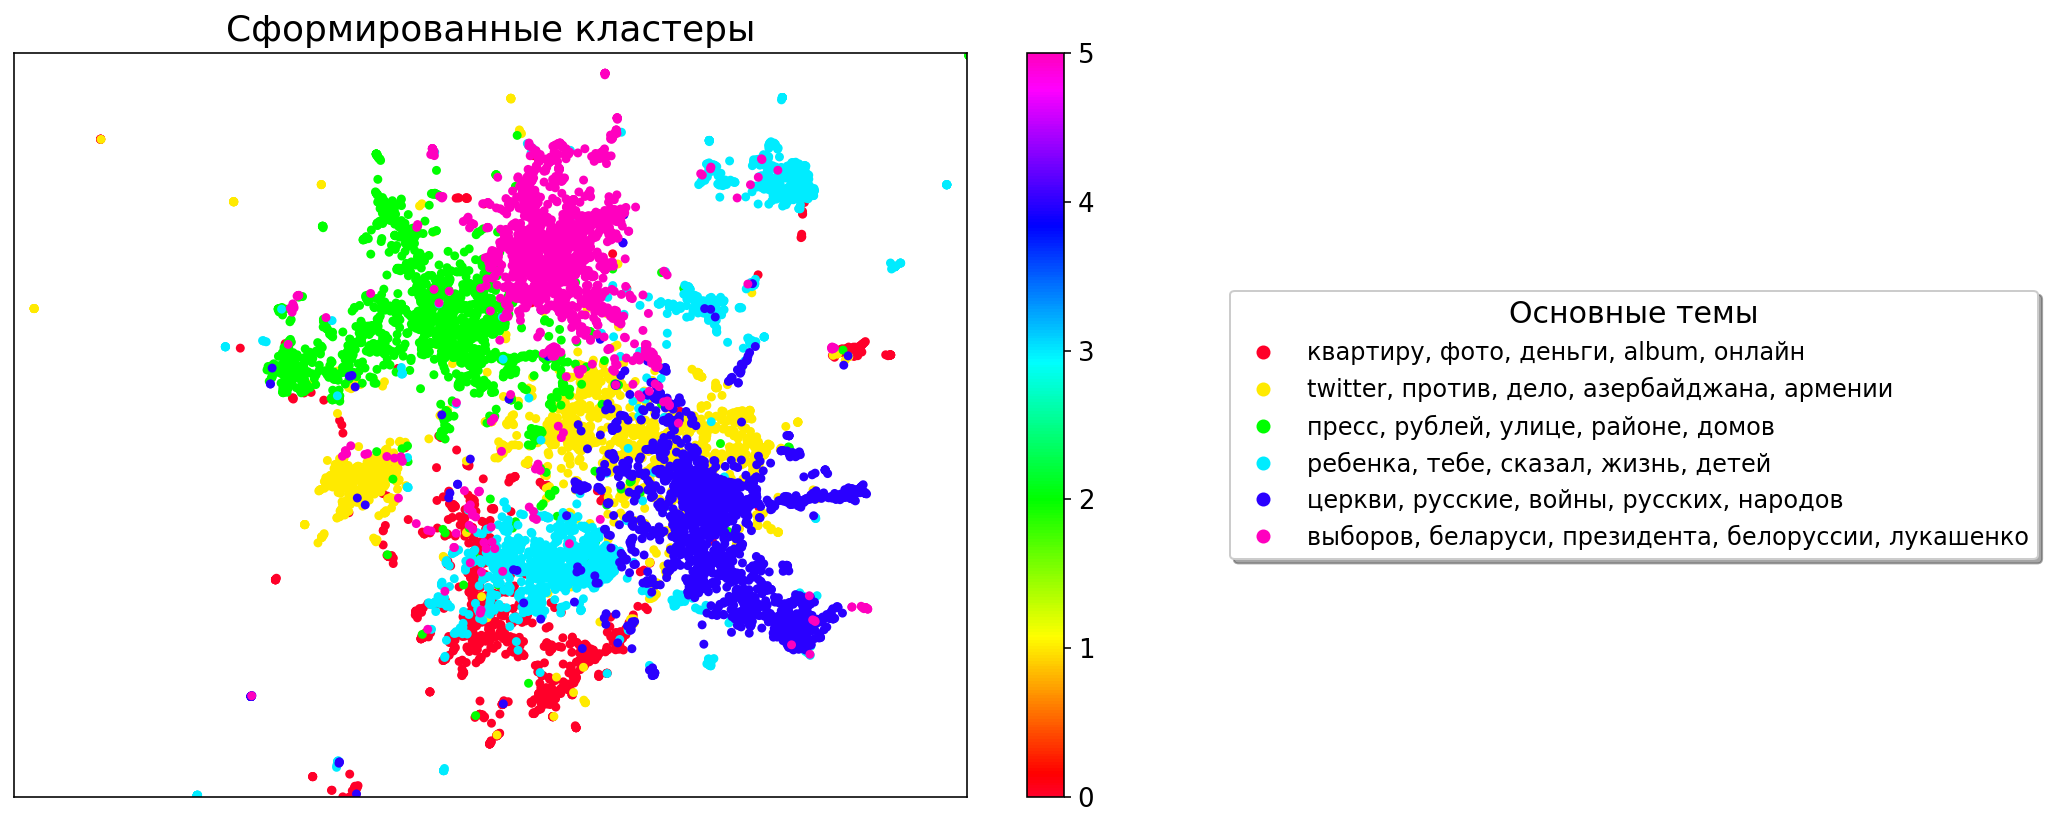

In [ ]:
# снижаем размерность для визуализации
umap_data = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster_labels

# визуализируем кластеры
#outliers = result.loc[result['labels'] == -1, :]
clustered = result.loc[result['labels'] != -1, :].sort_values(by='labels')
#plt.scatter(outliers['x'], outliers['y'], color='gray', s=12, alpha=0.5)
palette = ListedColormap(sns.color_palette('bright', len(set(labels))))

plt.figure(figsize=(16,6))
scatter = plt.scatter(clustered['x'], clustered['y'], c=clustered['labels'], s=12, cmap='gist_rainbow')
plt.colorbar()
plt.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
plt.legend(handles=scatter.legend_elements()[0], 
        title='Основные темы', 
        loc='center', 
        labels=terms,
        ncol=1,
        fontsize=12,
        fancybox=True,
        shadow=True,
        bbox_to_anchor=(1.7, 0.5))
plt.axis([0, 15, -2, 10])
plt.title('Сформированные кластеры')
#plt.show()
plt.tight_layout()
plt.savefig('Пример_визуализации.png', dpi=200, format='png')

In [ ]:
# провести кластеризацию (добавить к общему датасету)
# среднее кол-во сообщений в кластере должно быть не более 100-1000

# Построение трендов

In [ ]:
a = df['date'].iloc[0]

In [ ]:
a.split(' ')[0]

'2020-10-27'

In [ ]:
'.'.join(a.split('-')[:2])

'2020.10'

In [ ]:
from datetime import datetime

df['daily_date'] = df['date'].apply(lambda x: x.split(' ')[0])
df['daily_date'] = df['daily_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

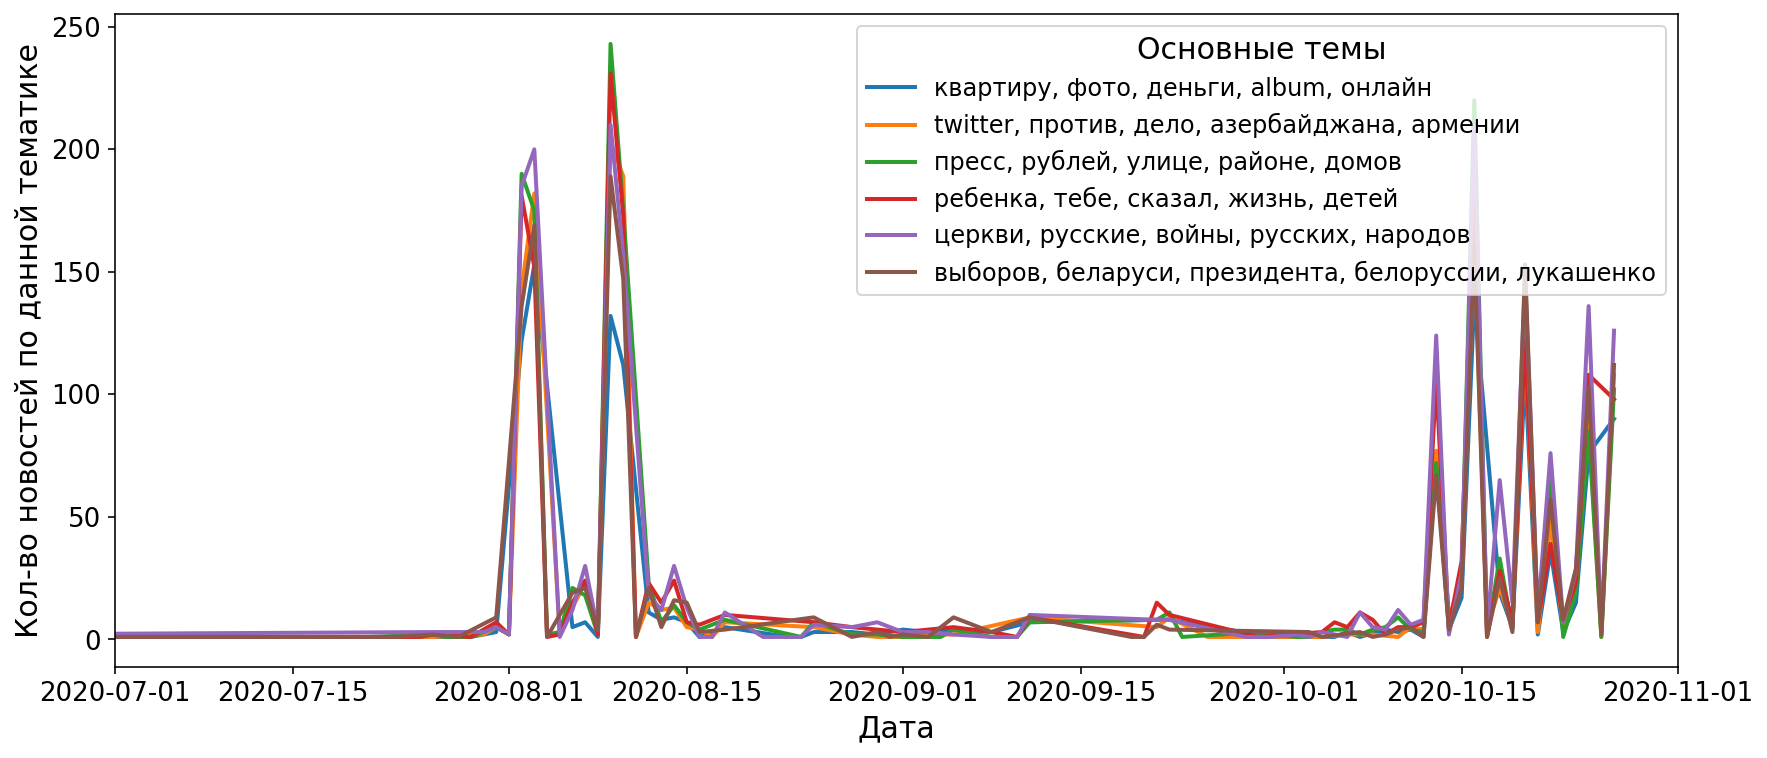

In [ ]:
df['clusters'] = cluster_labels

plt.figure(figsize=(14,6))

for i in range(len(set(df['clusters']))):
    plt.plot(df[df['clusters']==i]['daily_date'].value_counts().sort_index(), 
             lw=2,  label=terms[i])
    plt.xlim([datetime.strptime('07.2020', '%m.%Y'), datetime.strptime('11.2020', '%m.%Y')])

plt.legend(loc=0, title='Основные темы', fontsize=12)
plt.xlabel('Дата');
plt.ylabel('Кол-во новостей по данной тематике')
#plt.show()
plt.savefig('Пример_визуализации_2.png', dpi=200, format='png')